# 0.1. IMPORTS

In [61]:
import pandas as pd
from statsmodels.stats import api as sms
import math
from scipy.stats import ttest_1samp, shapiro, ttest_ind, mannwhitneyu, f_oneway
import numpy as np
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1.0. LOADING DATA

In [6]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\projeto_teste_AB\dataset\ab_data.csv") # r serve para abrir a pasta no windows
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


# 2.0. DESIGN DE EXPERIMENTS

## 2.1. PARAMETER OF EXPERIMENTS

In [7]:
# Nível de Confiança
confidence_level = 0.95

# Nível de Significância
significance_level = (1 - confidence_level)

# Conversões da página atual e nova
p1 = 0.13
p2 = 0.15

# Tamanho do efeito
effect_size = sms.proportion_effectsize(p1, p2)

# Poder Estatístico
power = 0.80

# Tamanho da amostra
sample_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = power,
    alpha = significance_level
)

sample_n = math.ceil(sample_n) # tira as casas decimais depois do ponto
sample_n


4720

In [8]:
conversion_rate = 0.1
x = sample_n / conversion_rate
print("O numero de email para enviar: {}".format(int(x)))
print("O numero total da base de email para enviar: {}".format(int(2*x)))

print("O tamanho total da amostra é de {}".format( 2*sample_n))
print("O tamanho da amostra do grupo controle é de: {}".format( sample_n))
print("O tamanho da amostra do grupo tratamento é de: {}".format( sample_n))

O numero de email para enviar: 47200
O numero total da base de email para enviar: 94400
O tamanho total da amostra é de 9440
O tamanho da amostra do grupo controle é de: 4720
O tamanho da amostra do grupo tratamento é de: 4720


In [9]:
# Análise descritiva dos dados

print(f"Number of rows: {df.shape[0]}")
print(f"Number of cols: {df.shape[1]}")

Number of rows: 294478
Number of cols: 5


In [10]:
# Verificar dados faltantes

df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

## 2.2. Conference is Flag of the Test A

In [11]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [12]:
df_user_deleted = df[["user_id", "group"]].groupby("user_id").count().reset_index().query('group > 1')
df_user_deleted = df_user_deleted["user_id"]

df1 = df[~df["user_id"].isin(df_user_deleted)] # o ~ significa que não(negação) quer as linhas e o isin filtra a lista

In [13]:
df1

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [14]:
df2 = df1[["user_id", "group", "landing_page"]].groupby(["group", "landing_page"]).count().reset_index()
df2

,group,landing_page,user_id
0,control,old_page,143293
1,treatment,new_page,143397


## 2.3. Amostragem Aleatória de Grupos - Controle e Tratamento

In [18]:
df_control_sample = df1[df1["group"] == "control"].sample(n = sample_n, random_state = 42)
print(f"Tamanho do Grupo de Controle {df_control_sample.shape[0]}")

df_treatment_sample = df1[df1["group"] == "treatment"].sample(n = sample_n, random_state = 42)
print(f"Tamanho do Grupo de Controle {df_treatment_sample.shape[0]}")

Tamanho do Grupo de Controle 4720
Tamanho do Grupo de Controle 4720


In [24]:
df_ab = pd.concat([df_control_sample, df_treatment_sample]).reset_index()
print(f"Total de Exemplos {df_ab.shape[0]}")

Total de Exemplos 9440


In [32]:
# Calculo da Métrica de Interesse
# grupo de controle
sales = df_control_sample.loc[df_control_sample["converted"] == 1, "converted"].sum()

# Quantidade de Visitantes
visit = len(df_control_sample)

# Converter os visitantes de controle
conversion_rate_control = sales / visit
print(f'Converstion Rate - Control Goup: {conversion_rate_control:.4f}') # 4 significa 4 casas decimais

# grupo de tratamento
sales = df_treatment_sample.loc[df_treatment_sample["converted"] == 1, "converted"].sum()

# Quantidade de Visitantes
visit = len(df_treatment_sample)

# Converter os visitantes de controle
conversion_rate_treatment = sales / visit
print(f'Converstion Rate - Treatment Goup: {conversion_rate_treatment:.4f}') # 4 significa 4 casas decimais


Converstion Rate - Control Goup: 0.1155
Converstion Rate - Treatment Goup: 0.1290


# 3.0. Testes Estatísticos

## 3.1 One-Sample Test

In [39]:
df = [14, 14, 16, 13, 12, 17, 15, 14, 15, 13, 15, 14]

# H0: 15 (Altura média das espécies das plantas de fato é 15cm )
# H1: <> = 15 (Altura média das espécies das plantas é diferente de é 15cm )

statstic, pvalue = ttest_1samp(df, popmean=15) # popmean(população media) é o H0:15
print (f'p-values: {pvalue}')
print(statstic)

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hiptese nula')
else:
    print('Falha em rejeitar a hipótese nula (Assumi a hipótese nula)')

p-values: 0.12014460742498101
-1.6848470783484626
Falha em rejeitar a hipótese nula (Assumi a hipótese nula)


## 3.2. Two-Sample Test (Condições Paramétricas são satisfeitas)

In [41]:
df1 = np.array([14, 15, 15, 16, 13, 8, 14, 17, 16, 14, 19, 20, 21, 15, 15, 16, 16, 13, 14, 12])
df2 = np.array([15, 17, 14, 17, 14, 8, 12, 19, 19, 14, 17, 22, 24, 16, 13, 16, 13, 18, 15, 13])


# H0: u1 = u2 (Altura média das espécies dos grupos de plantas são iguais )
# H1: <> = 15 (Altura média das espécies dos grupos de plantas são diferente)
print (np.mean(df1))
print (np.mean(df2))

15.15
15.8


In [ ]:
# Condições paramétricas

# 1. Amostras Independentes
# 2. Normamente distribuídos

## Teste de Normalidade - Shapiro # testa a normalidade dos dados
# H0: Distribuição não normal
# H1: Distribuição normalmente distribuido

# if pvalue < alpha
#  print ('Rejeito a hipótese nula')
#  pvalue = 0.0001 - Digo que não é normal # valor arbitrario
#
# else
#  print('Falha em rejeitar a hipótese nula')
#  pvalue = 0.89392 - é normal # valor arbitratrio
#
stats1, pvalue1 = shapiro(df1)
print(f'p-value1: {pvalue1}')

stats2, pvalue2 = shapiro(df2)
print(f'p-value2: {pvalue2}')


# 3. Variancias iguais
print(f'\nVar 1: {np.var(df1)}') # \nVar o \n significa pular uma linha
print(f'Var 2: {np.var(df2)}')


stats, pvalue = ttest_ind(df1, df2, equal_var=True)
print(f'p-value: {pvalue}')

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hipótese nula')

else:
    print('Falha em rejeitar a hipótese nula')
   

p-value1: 0.226775856925707
p-value2: 0.6782103872264504

Var 1: 7.727500000000001
Var 2: 12.260000000000002
p-value: 0.5300471010405257
Falha em rejeitar a hipótese nula


## 3.3. Mann-Whitney U-test (Condições Paramétricas são satisfeitas)

In [45]:
df1 = [20, 23, 21, 20, 18, 17, 18, 14, 20, 24, 43, 19]
df2 = [24, 25, 21, 22, 23, 18, 17, 28, 24, 27, 21, 23]

In [46]:
np.mean(df1)

np.float64(21.416666666666668)

In [47]:
np.mean(df2)

np.float64(22.75)

In [ ]:
# Condições paramétricas

# 1. Amostras Indepedents
# 2. Normamente distrinuídos

## Teste de Normalidade - Shapiro
# H0: Distribuição não normal
# H1: Distribuição normalmente distribuido

# if pvalue < alpha
#  print ('Rejeito a hipótese nula')
#  pvalue = 0.0001 - Digo que não é normal
#
# else
#  print('Falha em rejeitar a hipótese nula')
#  pvalue = 0.89392 - é normal
#
stats1, pvalue1 = shapiro(df1)
print(f'p-value1: {pvalue1}')

stats2, pvalue2 = shapiro(df2)
print(f'p-value2: {pvalue2}')


# 3. Variancias iguais
print(f'\nVar 1: {np.var(df1)}')
print(f'Var 2: {np.var(df2)}')


stats, pvalue = mannwhitneyu(df1, df2)
print(f'p-value: {pvalue}')

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hipótese nula')

else:
    print('Falha em rejeitar a hipótese nula')
    

## 3.4. Anova

In [54]:
df = pd.DataFrame({'A': [25, 30, 28, 36, 29],
                   'B': [45, 55, 29, 56, 40],
                   'C': [30, 29, 33, 37, 27],
                   'D': [54, 60, 51, 62, 73]})

In [55]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
df_melt.columns = ['index', 'treatment', 'value']
df_melt.head()

,index,treatment,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29


<Axes: xlabel='treatment', ylabel='value'>

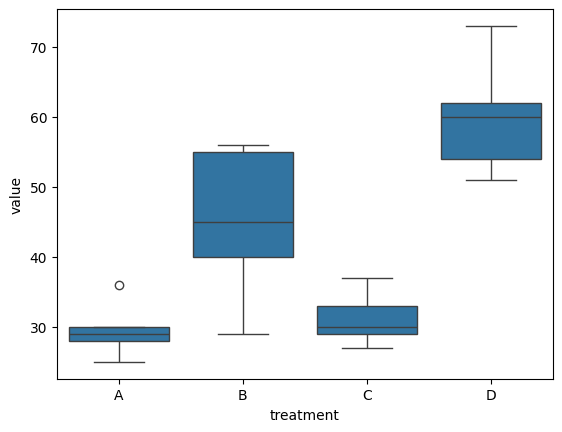

In [56]:
sns.boxplot(x='treatment', y='value', data=df_melt)

In [58]:
print(f'pvalue - Grupo A: {shapiro(df["A"])}')
print(f'pvalue - Grupo B: {shapiro(df["B"])}')
print(f'pvalue - Grupo C: {shapiro(df["C"])}')
print(f'pvalue - Grupo D: {shapiro(df["D"])}')

print(f'\nVariance - Grupo A: {np.var(df["A"])}')
print(f'Variance - Grupo B: {np.var(df["B"])}')
print(f'Variance - Grupo C: {np.var(df["C"])}')
print(f'Variance - Grupo D: {np.var(df["D"])}')

pvalue - Grupo A: ShapiroResult(statistic=np.float64(0.9316344846564609), pvalue=np.float64(0.6075583653996472))
pvalue - Grupo B: ShapiroResult(statistic=np.float64(0.9264495969759936), pvalue=np.float64(0.5723675006691977))
pvalue - Grupo C: ShapiroResult(statistic=np.float64(0.9529604619046342), pvalue=np.float64(0.7583121101708065))
pvalue - Grupo D: ShapiroResult(statistic=np.float64(0.9448274077499924), pvalue=np.float64(0.7002370626370356))

Variance - Grupo A: 13.040000000000001
Variance - Grupo B: 100.4
Variance - Grupo C: 12.16
Variance - Grupo D: 58.0


In [59]:
stats, pvalue = f_oneway(df['A'], df['B'], df['C'], df['D'])
print(f'pvalue: {pvalue}')


# H0: Não há diferença na altura média
# H1: Há diferença na altura média

alpha = 0.05

if pvalue < alpha:
    print('Rejeita a hipótese nula')
else:
    print('Falha em rejeita a hipotese nula - Aceita a H0')

pvalue: 2.6392411462109217e-05
Rejeita a hipótese nula


In [ ]:
tukey = pairwise_tukeyhsd(endog=df_melt['value'], 
                          groups=df_melt['treatment'],
                          alpha=0.05)
print(tukey) 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     15.4 0.0251   1.694 29.106   True
     A      C      1.6 0.9867 -12.106 15.306  False
     A      D     30.4 0.0001  16.694 44.106   True
     B      C    -13.8 0.0482 -27.506 -0.094   True
     B      D     15.0 0.0296   1.294 28.706   True
     C      D     28.8 0.0001  15.094 42.506   True
---------------------------------------------------
